In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_linear(n = 100):
    import numpy as np
    pts = np.random.uniform(0, 1, (n, 2))   # lower bound is 0, upper bound is 1, 創立n個點, 每個點是二維
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])   # pt[0]: x座標, pt[1]: y座標
        dist = (pt[0] - pt[1]) / 1.414  # 1.414: 根號2的近似值
        if pt[0] > pt[1]:   # if x坐標 > y座標, label設為0 (為紅點)
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1) # n列1行
    
def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1 * i == 0.5:  # skip the point of (0.5, 0.5)
            continue
        
        inputs.append([0.1*i, 1 - 0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21, 1)

def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    
    plt.subplot(2, 2, 3)
    plt.title("Ground Truth", fontsize = 18)
    
    for i in range(x.shape[0]):
        if y[i] == 0:   # if label為0 -> 標示紅點
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
            
    plt.subplot(2, 2, 4)
    
    # 顯示accuracy, 並置於 (0, 0) 位置，設置字體大小和背景框
    plt.text( 0, 0, f'Accuracy: { sum(pred_y == y) / y.size }', fontsize = 16,  # sum( pred_y == y ) : 代表命中多少次
        bbox = dict( facecolor = 'white', alpha = 0.5 ) )
    
    plt.title("Predict Result", fontsize = 18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
            
    plt.show()

In [2]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def derivative_sigmoid(x):
    sig = sigmoid(x)
    return np.multiply(sig, 1.0 - sig)

def ReLU(x):
    return np.where(x > 0, x, 0)

def derivative_ReLU(x):
    return np.where(x > 0, 1, 0)  # 修正這行以處理 x 為陣列的情況
    
def tanh(x):
    return np.tanh(x)

def derivative_tanh(x):
    return 1 - np.multiply(x, x)
   

def MSE_Loss(y_true, y_pred):   # define loss function
    return np.mean((y_pred - y_true) ** 2)

def derivative_MSE_Loss(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

class TwoLayerNN:
    # initiate weight and bias
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.w1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2. / input_size)  # Xavier 初始化
        self.b1 = np.zeros((1, hidden_size1)) 
        self.w2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2. / input_size)  
        self.b2 = np.zeros((1, hidden_size2))
        self.w3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2. / input_size)  
        self.b3 = np.zeros((1, output_size))
    
    # 前面兩層用ReLU, 最後用Sigmoid
    # to implement forward pass    
    def forward(self, x):
        self.z1 = np.matmul(x, self.w1) + self.b1
        self.a1 = ReLU(self.z1)
        
        self.z2 = np.matmul(self.a1, self.w2) + self.b2
        self.a2 = ReLU(self.z2)
        
        self.z3 = np.matmul(self.a2, self.w3) + self.b3
        self.a3 = sigmoid(self.z3)
        return self.a3
    
    def backward(self, x, y):
        loss_gradient = derivative_MSE_Loss(y, self.a3)
        d_z3 = loss_gradient * derivative_sigmoid(self.z3)
        
        d_w3 = np.dot(self.a2.T, d_z3)
        d_b3 = np.sum(d_z3, axis = 0, keepdims = True)   # keepdim = true: 確保d_b3的維度跟b3的一致
        
        d_a2 = np.dot(d_z3, self.w3.T)  # z3 = a2 * w3 + b3
        d_z2 = d_a2 * derivative_ReLU(self.z2)
        d_w2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis = 0, keepdims = True)   # axis = 0: 將每列的 d_z2 進行求和
        
        d_a1 = np.matmul(d_z2, self.w2.T)
        d_z1 = d_a1 * derivative_ReLU(self.z1)
        d_w1 = np.matmul(x.T, d_z1)
        d_b1 = np.sum(d_z1, axis = 0, keepdims = True)
        
        # update weight and bias
        learning_rate = 1e-2
        self.w1 -= learning_rate * d_w1
        self.w2 -= learning_rate * d_w2
        self.w3 -= learning_rate * d_w3
        self.b1 -= learning_rate * d_b1
        self.b2 -= learning_rate * d_b2
        self.b3 -= learning_rate * d_b3
        
    def train(self, x, y, epochs):
        import matplotlib.pyplot as plt
        
        self.loss = []
        for epoch in range(epochs):
            self.y_pred = self.forward(x)
            self.backward(x, y)
            loss = MSE_Loss(y, self.y_pred)
            self.loss.append(loss)
            
            if epoch % 1000 == 0:
                print(f"Epoch: {epoch}, Loss: {loss}")
            
        # plot the learning curve
        plt.subplot(2, 1, 1)    # 在2列1行的圖形中的第一個位置繪製 (即上半部)
        plt.title("Learning Curve", fontsize = 18)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(self.loss)
                
    def show_result(self, x, y):
        accuracy = sum((self.y_pred > 0.5) == (y == 1)) / y.size    # 預測值 > 0.5 且 y為1 的情況數 再除以y.size
        print(f"Accruracy: {accuracy}")
        print("Prediction: ")
        
        for i in range(y.size):
            print(f"Iter{i+1} |  Ground truth: {y[i]}  |   Prediction: {self.y_pred[i]}")  
        show_result(x, y, self.y_pred > 0.5)      

Epoch: 0, Loss: 0.22388953061687555
Epoch: 1000, Loss: 0.1155097468606922
Epoch: 2000, Loss: 0.07837856811133471
Epoch: 3000, Loss: 0.05929881593949928
Epoch: 4000, Loss: 0.048408793071423935
Epoch: 5000, Loss: 0.041482794220013275
Epoch: 6000, Loss: 0.03669071625900016
Epoch: 7000, Loss: 0.03316868839480448
Epoch: 8000, Loss: 0.030437177864155753
Epoch: 9000, Loss: 0.028243098204371462
Epoch: 10000, Loss: 0.02642270698187808
Epoch: 11000, Loss: 0.02488496033833105
Epoch: 12000, Loss: 0.023582820663935973
Epoch: 13000, Loss: 0.02243694532118769
Epoch: 14000, Loss: 0.021415166208470737
Epoch: 15000, Loss: 0.02049488586326882
Epoch: 16000, Loss: 0.019659048996406966
Epoch: 17000, Loss: 0.018894587648864196
Epoch: 18000, Loss: 0.018194541855181098
Epoch: 19000, Loss: 0.017556158536593112
Accruracy: [1.]
Prediction: 
Iter1 |  Ground truth: [1]  |   Prediction: [0.99420769]
Iter2 |  Ground truth: [0]  |   Prediction: [0.07180394]
Iter3 |  Ground truth: [0]  |   Prediction: [0.07180394]
Iter

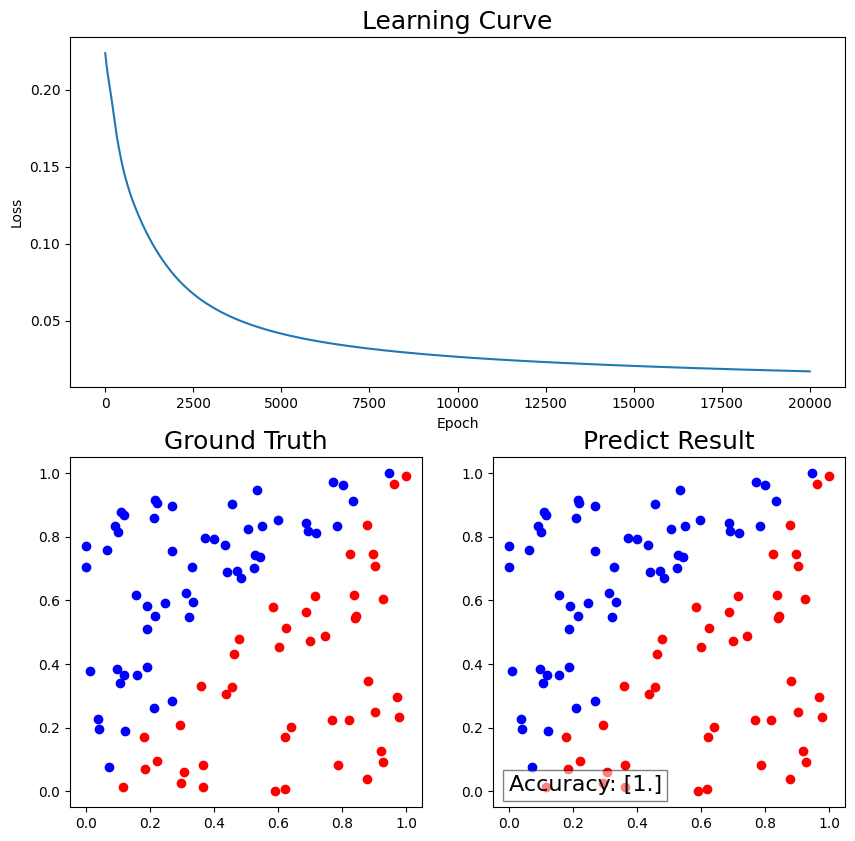

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize = (10, 10))   # 調整圖片大小為長寬 10 x 10 英吋

x, y = generate_linear(n = 100)
scaler = MinMaxScaler()
x = scaler.fit_transform(x)  # 標準化輸入數據
 
nn = TwoLayerNN(input_size = 2, hidden_size1 = 4, hidden_size2 = 4, output_size = 1)
nn.train(x, y, epochs = 20000)
y_pred = nn.forward(x)
y_pred = (y_pred > 0.5).astype(int)

nn.show_result(x, y)   # 這邊記得是呼叫 model 裡的show_result

Epoch: 0, Loss: 0.29728546579422455
Epoch: 1000, Loss: 0.24642800261979483
Epoch: 2000, Loss: 0.23946718817753415
Epoch: 3000, Loss: 0.21934322053005392
Epoch: 4000, Loss: 0.1895842593492339
Epoch: 5000, Loss: 0.15174862967146543
Epoch: 6000, Loss: 0.11204374359675169
Epoch: 7000, Loss: 0.08121998168003637
Epoch: 8000, Loss: 0.06116489587644271
Epoch: 9000, Loss: 0.04813245756050418
Epoch: 10000, Loss: 0.038766729918757986
Epoch: 11000, Loss: 0.031676278826545765
Epoch: 12000, Loss: 0.026376164291366334
Epoch: 13000, Loss: 0.02218779145158619
Epoch: 14000, Loss: 0.018769568876571174
Epoch: 15000, Loss: 0.01612185196203502
Epoch: 16000, Loss: 0.013919255312856043
Epoch: 17000, Loss: 0.012156650388443772
Epoch: 18000, Loss: 0.010702442079664136
Epoch: 19000, Loss: 0.009482347368877101
Accruracy: [1.]
Prediction: 
Iter1 |  Ground truth: [0]  |   Prediction: [0.067196]
Iter2 |  Ground truth: [1]  |   Prediction: [0.99999922]
Iter3 |  Ground truth: [0]  |   Prediction: [0.06515917]
Iter4 | 

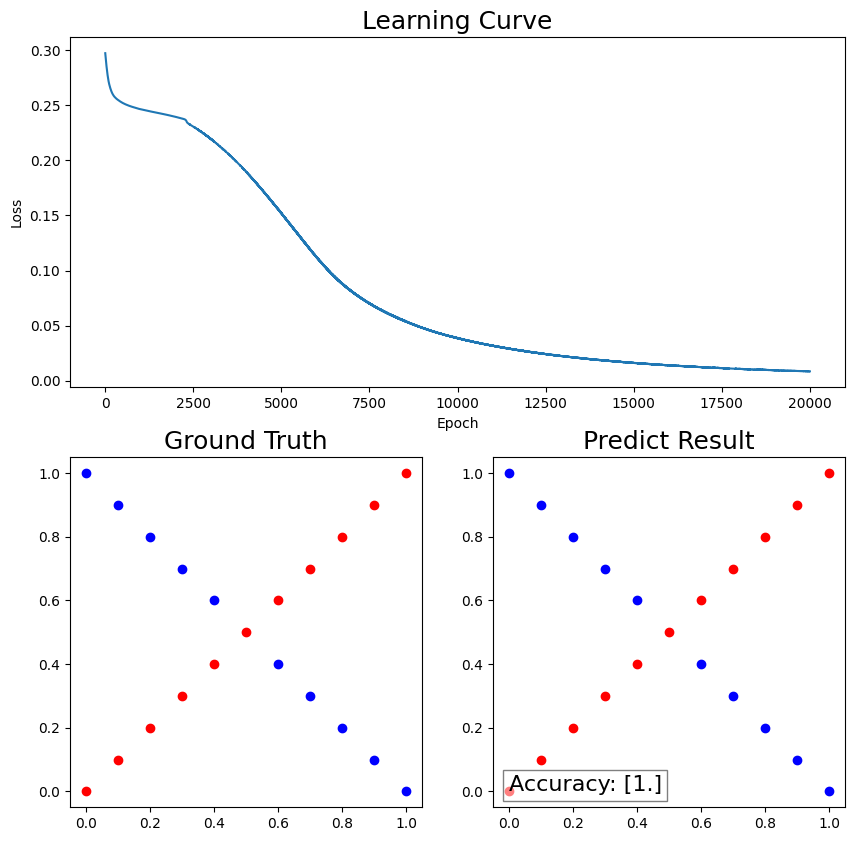

In [4]:
plt.figure(figsize = (10, 10))
x, y = generate_XOR_easy()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)  # 標準化輸入數據
 
nn = TwoLayerNN(input_size = 2, hidden_size1 = 4, hidden_size2 = 4, output_size = 1)
nn.train(x, y, epochs = 20000)
y_pred = nn.forward(x)
y_pred = (y_pred > 0.5).astype(int)

nn.show_result(x, y)   # 這邊記得是呼叫 model 裡的show_result

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize = (10, 10))   # 調整圖片大小為長寬 10 x 10 英吋

x, y = generate_linear(n = 100)
scaler = MinMaxScaler()
x = scaler.fit_transform(x)  # 標準化輸入數據
 
nn = TwoLayerNN(input_size = 2, hidden_size1 = 4, hidden_size2 = 4, output_size = 1)
nn.train(x, y, epochs = 10000)
y_pred = nn.forward(x)
y_pred = (y_pred > 0.5).astype(int)

nn.show_result(x, y)   # 這邊記得是呼叫 model 裡的show_result